In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [2]:
from google.colab import files
import pandas as pd

# Upload the CSV file
uploaded = files.upload()


Saving World_SeaborneTrade_CLEAN.csv to World_SeaborneTrade_CLEAN (2).csv


In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv("World_SeaborneTrade_CLEAN (2).csv")
df = df.reset_index(drop=True)

# Keep only needed columns (INCLUDING LABEL)
df = df[
    ['Year', 'Economy', 'CargoType', 'CargoType Label', 'Trade_million_tons']
]

# Remove NaN / inf
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

# HARD lower bound (domain-safe)
MIN_TRADE = 0.1  # million tons
df = df[df['Trade_million_tons'] >= MIN_TRADE].reset_index(drop=True)

print("Min trade after filter:", df['Trade_million_tons'].min())
print(df.columns)




Min trade after filter: 0.100038
Index(['Year', 'Economy', 'CargoType', 'CargoType Label',
       'Trade_million_tons'],
      dtype='object')


In [4]:
# Keep only years 2000–2023
df = df[(df['Year'] >= 2000) & (df['Year'] <= 2023)].reset_index(drop=True)

print("Year range after filter:", df['Year'].min(), df['Year'].max())

Year range after filter: 2000 2023


In [5]:
# 2 Encode categorical features
from sklearn.preprocessing import LabelEncoder

economy_encoder = LabelEncoder()
cargo_encoder = LabelEncoder()

df['Economy_enc'] = economy_encoder.fit_transform(df['Economy'])
df['CargoType_enc'] = cargo_encoder.fit_transform(df['CargoType'])


In [6]:
# Safe log transform
df['Trade_log'] = np.log1p(df['Trade_million_tons'])

# Scale (required)
from sklearn.preprocessing import MinMaxScaler
scaler_y = MinMaxScaler()
df['Trade_scaled'] = scaler_y.fit_transform(df[['Trade_log']])


In [7]:
print(df[['Trade_million_tons','Trade_log','Trade_scaled']].describe())


       Trade_million_tons     Trade_log  Trade_scaled
count        41028.000000  41028.000000  41028.000000
mean           252.277078      2.961851      0.309262
std            787.921654      2.281574      0.246155
min              0.100038      0.095345      0.000000
25%              1.529985      0.928213      0.089857
50%             11.479088      2.524054      0.262029
75%            100.050037      4.615616      0.487684
max          11662.167570      9.364191      1.000000


In [8]:
# 3 Create sequences (WITH CargoType Label)
time_steps = 5

def create_sequences(df):
    X, y, meta = [], [], []

    for (_, _), g in df.groupby(['Economy_enc', 'CargoType_enc']):
        g = g.sort_values('Year')

        if len(g) <= time_steps:
            continue

        values = g['Trade_scaled'].values

        for i in range(len(values) - time_steps):
            X.append(values[i:i+time_steps])
            y.append(values[i+time_steps])

            meta.append({
                'Economy_enc': g.iloc[i+time_steps]['Economy_enc'],
                'CargoType_enc': g.iloc[i+time_steps]['CargoType_enc'],
                'CargoType Label': g.iloc[i+time_steps]['CargoType Label'],  # ✅ الإضافة هنا
                'Year': g.iloc[i+time_steps]['Year']
            })

    return np.array(X), np.array(y), pd.DataFrame(meta)

X_seq, y_seq, meta = create_sequences(df)

In [9]:
print(meta.head())
print(meta.columns)

   Economy_enc  CargoType_enc     CargoType Label  Year
0            0              0  Total goods loaded  2005
1            0              0  Total goods loaded  2006
2            0              0  Total goods loaded  2007
3            0              0  Total goods loaded  2008
4            0              0  Total goods loaded  2009
Index(['Economy_enc', 'CargoType_enc', 'CargoType Label', 'Year'], dtype='object')


In [9]:
print("X NaN:", np.isnan(X_seq).sum())
print("y NaN:", np.isnan(y_seq).sum())
print("X inf:", np.isinf(X_seq).sum())
print("y inf:", np.isinf(y_seq).sum())


X NaN: 0
y NaN: 0
X inf: 0
y inf: 0


In [10]:
split_year = meta['Year'].quantile(0.8)

train_idx = meta['Year'] <= split_year
test_idx  = meta['Year'] > split_year

X_train = X_seq[train_idx]
X_test  = X_seq[test_idx]

y_train = y_seq[train_idx]
y_test  = y_seq[test_idx]

meta_train = meta[train_idx].reset_index(drop=True)
meta_test  = meta[test_idx].reset_index(drop=True)


In [11]:
print("X_train shape:", X_train.shape)
print("X_test shape :", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape :", y_test.shape)

print("Train years:", meta_train['Year'].min(), meta_train['Year'].max())
print("Test years :", meta_test['Year'].min(), meta_test['Year'].max())

X_train shape: (26359, 5)
X_test shape : (5111, 5)
y_train shape: (26359,)
y_test shape : (5111,)
Train years: 2005 2020
Test years : 2021 2023


In [12]:
X_train = X_train.reshape(X_train.shape[0], time_steps, 1)
X_test  = X_test.reshape(X_test.shape[0], time_steps, 1)

In [12]:
print("Before:", X_train.shape, X_test.shape)


Before: (26359, 5) (5111, 5)


In [13]:
X_train = X_train.reshape(X_train.shape[0], time_steps, 1)
X_test  = X_test.reshape(X_test.shape[0], time_steps, 1)

print("After:", X_train.shape, X_test.shape)


After: (26359, 5, 1) (5111, 5, 1)


In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

inp = Input(shape=(time_steps, 1))
x = LSTM(64, recurrent_dropout=0.1)(inp)
x = Dropout(0.2)(x)
out = Dense(1)(x)

model = Model(inp, out)
model.compile(optimizer=Adam(0.001), loss='mse')
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)


Epoch 1/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0142 - val_loss: 7.3877e-04
Epoch 2/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0012 - val_loss: 9.2146e-04
Epoch 3/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0010 - val_loss: 6.8178e-04
Epoch 4/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 8.7606e-04 - val_loss: 5.4864e-04
Epoch 5/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 7.9006e-04 - val_loss: 5.9461e-04
Epoch 6/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 7.1964e-04 - val_loss: 4.8255e-04
Epoch 7/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 6.5917e-04 - val_loss: 5.2576e-04
Epoch 8/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 6.7922e-04 - val_loss: 4.3894e-04
Epoch 9/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 6.4352e-04 - val_loss: 4.1726e-04
Epoch 10/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 6.1420e-04 - val_loss: 4.4152e-04
Epoch 11/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 6.3439e

In [17]:
y_train_pred_scaled = model.predict(X_train, verbose=0)
y_test_pred_scaled  = model.predict(X_test,  verbose=0)


In [18]:
# Ensure shapes are (N, 1)
y_train_scaled_2d = np.asarray(y_train).reshape(-1, 1)
y_test_scaled_2d  = np.asarray(y_test).reshape(-1, 1)

y_train_pred_scaled_2d = np.asarray(y_train_pred_scaled).reshape(-1, 1)
y_test_pred_scaled_2d  = np.asarray(y_test_pred_scaled).reshape(-1, 1)

# Inverse scaling → log space
y_train_true_log = scaler_y.inverse_transform(y_train_scaled_2d)
y_test_true_log  = scaler_y.inverse_transform(y_test_scaled_2d)

y_train_pred_log = scaler_y.inverse_transform(y_train_pred_scaled_2d)
y_test_pred_log  = scaler_y.inverse_transform(y_test_pred_scaled_2d)

In [19]:
y_train_true = np.expm1(y_train_true_log)
y_test_true  = np.expm1(y_test_true_log)

y_train_pred = np.expm1(y_train_pred_log)
y_test_pred  = np.expm1(y_test_pred_log)


In [20]:
# ---- Train ----
pred_train_df = meta_train.copy()
pred_train_df['Trade_pred_million'] = y_train_pred.flatten()
pred_train_df['Trade_true_million'] = y_train_true.flatten()
pred_train_df['Economy'] = economy_encoder.inverse_transform(
    pred_train_df['Economy_enc'].astype(int)
)
pred_train_df['CargoType'] = cargo_encoder.inverse_transform(
    pred_train_df['CargoType_enc'].astype(int)
)

# ---- Test ----
pred_test_df = meta_test.copy()
pred_test_df['Trade_pred_million'] = y_test_pred.flatten()
pred_test_df['Trade_true_million'] = y_test_true.flatten()
pred_test_df['Economy'] = economy_encoder.inverse_transform(
    pred_test_df['Economy_enc'].astype(int)
)
pred_test_df['CargoType'] = cargo_encoder.inverse_transform(
    pred_test_df['CargoType_enc'].astype(int)
)

In [21]:
def safe_percentage_error(y_true, y_pred, min_value=1.0):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = y_true >= min_value
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs(y_true[mask] - y_pred[mask]) / y_true[mask]) * 100


In [22]:
from sklearn.metrics import r2_score, mean_squared_error

def compute_metrics(df, pe_func, min_value=1.0):
    metrics = []
    for cargo, g in df.groupby('CargoType Label'):
        if len(g['Trade_true_million'].unique()) > 1:
            rmse = np.sqrt(mean_squared_error(
                g['Trade_true_million'],
                g['Trade_pred_million']
            ))
            r2 = r2_score(
                g['Trade_true_million'],
                g['Trade_pred_million']
            )
            pe = pe_func(
                g['Trade_true_million'],
                g['Trade_pred_million'],
                min_value=min_value
            )
        else:
            rmse = r2 = pe = np.nan

        metrics.append({
            'CargoType Label': cargo,
            'RMSE': rmse,
            'R2': r2,
            'PE': pe,
            'N': len(g)
        })
    return pd.DataFrame(metrics)

In [23]:
metrics_train_df = compute_metrics(
    pred_train_df,
    safe_percentage_error,
    min_value=1.0
)

metrics_test_df = compute_metrics(
    pred_test_df,
    safe_percentage_error,
    min_value=1.0
)

In [28]:
metrics_df = (
    pd.merge(
        metrics_train_df,
        metrics_test_df,
        on='CargoType Label',
        suffixes=('_Train', '_Test')
    )
    .rename(columns={
        'RMSE_Train': 'Train_RMSE',
        'R2_Train':   'Train_R2',
        'PE_Train':   'Train_PE',
        'RMSE_Test':  'Test_RMSE',
        'R2_Test':    'Test_R2',
        'PE_Test':    'Test_PE',
        'N_Train':    'N_Train',
        'N_Test':     'N_Test'
    })
    .round(2)
)

print("✅ Combined Metrics (Train vs Test)")
print(metrics_df)

✅ Combined Metrics (Train vs Test)
                 CargoType Label  Train_RMSE  Train_R2  Train_PE  N_Train  \
0           Crude oil discharged       28.74      0.99     14.19     2179   
1               Crude oil loaded       28.03      0.99     15.76     2097   
2           Dry cargo discharged       91.57      0.99     10.94     3949   
3               Dry cargo loaded       80.63      0.99     10.87     3708   
4  Other tanker trade discharged       23.87      0.99     14.35     3644   
5      Other tanker trade loaded       23.96      0.99     14.33     2913   
6         Total goods discharged      139.40      0.99     11.30     4034   
7             Total goods loaded      122.04      0.99     10.83     3835   

   Test_RMSE  Test_R2  Test_PE  N_Test  
0      23.65     1.00    18.90     389  
1      25.30     0.99    16.13     415  
2      71.93     0.99     9.00     779  
3      69.97     0.99     9.77     713  
4      23.12     0.99    15.50     728  
5      26.25     0.99    

In [25]:
selected_cargo_labels = [
    'Crude oil loaded',
    'Other tanker trade loaded',
    'Dry cargo loaded',
    'Total goods loaded'
]

metrics_df_filtered = metrics_df[
    metrics_df['CargoType Label'].isin(selected_cargo_labels)
].reset_index(drop=True)

print("✅ Metrics for selected cargo types only:")
print(metrics_df_filtered)

✅ Metrics for selected cargo types only:
             CargoType Label  Train_RMSE  Train_R2  Train_PE  N_Train  \
0           Crude oil loaded       28.03      0.99     15.76     2097   
1           Dry cargo loaded       80.63      0.99     10.87     3708   
2  Other tanker trade loaded       23.96      0.99     14.33     2913   
3         Total goods loaded      122.04      0.99     10.83     3835   

   Test_RMSE  Test_R2  Test_PE  N_Test  
0      25.30     0.99    16.13     415  
1      69.97     0.99     9.77     713  
2      26.25     0.99    15.41     563  
3     115.88     0.99    10.20     734  


In [30]:
metrics_all = metrics_train_df.merge(
    metrics_test_df,
    on='CargoType Label',
    suffixes=('_Train', '_Test')
)

display(metrics_all)

,CargoType Label,RMSE_Train,R2_Train,PE_Train,N_Train,RMSE_Test,R2_Test,PE_Test,N_Test
0,Crude oil discharged,28.741612,0.992891,14.187748,2179,23.645358,0.995788,18.901892,389
1,Crude oil loaded,28.034703,0.994090,15.758278,2097,25.303679,0.994917,16.126968,415
2,Dry cargo discharged,91.572269,0.986791,10.936277,3949,71.926913,0.994620,8.999622,779
3,Dry cargo loaded,80.630357,0.988752,10.867585,3708,69.965608,0.994276,9.771037,713
4,Other tanker trade discharged,23.873712,0.989479,14.354108,3644,23.124416,0.993119,15.502671,728
5,Other tanker trade loaded,23.957008,0.990414,14.328856,2913,26.250661,0.992633,15.405920,563
6,Total goods discharged,139.402236,0.987802,11.300101,4034,118.531120,0.993799,9.479895,790
7,Total goods loaded,122.041617,0.989525,10.826590,3835,115.881160,0.993338,10.202575,734


In [33]:
import matplotlib.pyplot as plt

# 🔹 فقط CargoTypes اللي تحتوي على "loaded"
loaded_cargo_types = [
    c for c in pred_train_df['CargoType Label'].unique()
    if 'loaded' in c.lower()
]

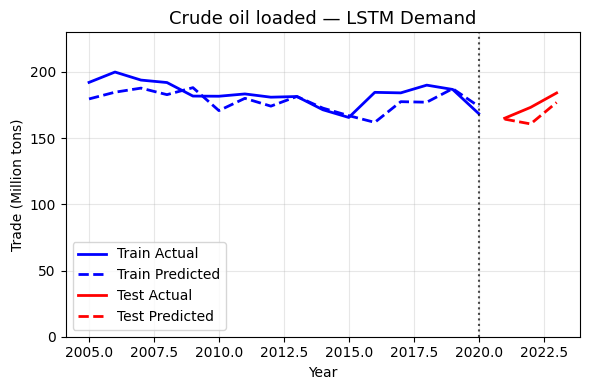

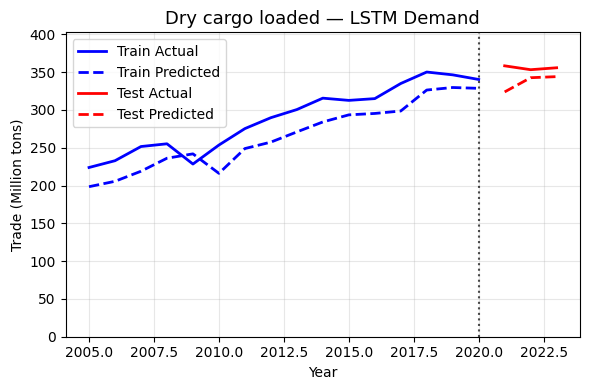

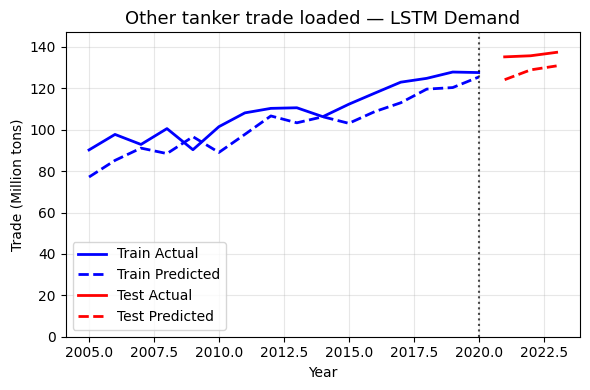

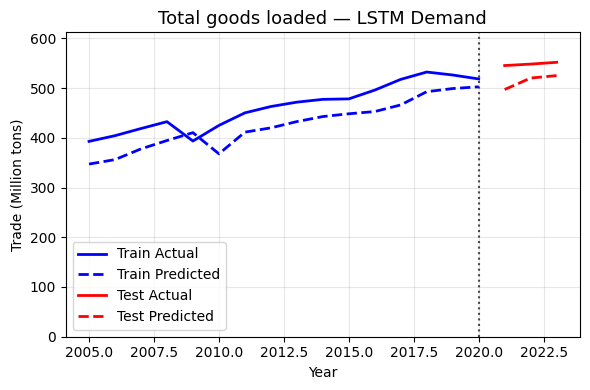

In [34]:
for cargo in sorted(loaded_cargo_types):

    # ===== Train =====
    train_g = (
        pred_train_df[pred_train_df['CargoType Label'] == cargo]
        .groupby('Year', as_index=False)
        .agg({
            'Trade_true_million': 'mean',
            'Trade_pred_million': 'mean'
        })
        .sort_values('Year')
    )

    # ===== Test =====
    test_g = (
        pred_test_df[pred_test_df['CargoType Label'] == cargo]
        .groupby('Year', as_index=False)
        .agg({
            'Trade_true_million': 'mean',
            'Trade_pred_million': 'mean'
        })
        .sort_values('Year')
    )

    if train_g.empty or test_g.empty:
        continue

    plt.figure(figsize=(6, 4))

    # ---- Train ----
    plt.plot(
        train_g['Year'], train_g['Trade_true_million'],
        color='blue', linewidth=2, label='Train Actual'
    )
    plt.plot(
        train_g['Year'], train_g['Trade_pred_million'],
        color='blue', linestyle='--', linewidth=2, label='Train Predicted'
    )

    # ---- Test ----
    plt.plot(
        test_g['Year'], test_g['Trade_true_million'],
        color='red', linewidth=2, label='Test Actual'
    )
    plt.plot(
        test_g['Year'], test_g['Trade_pred_million'],
        color='red', linestyle='--', linewidth=2, label='Test Predicted'
    )

    # Split line
    split_year = train_g['Year'].max()
    plt.axvline(split_year, color='black', linestyle=':', alpha=0.7)

    # Fix Y-axis
    ymax = train_g['Trade_true_million'].max()
    plt.ylim(0, ymax * 1.15)

    plt.title(f'{cargo} — LSTM Demand', fontsize=13)
    plt.xlabel('Year')
    plt.ylabel('Trade (Million tons)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
